In [1]:
import json
import os
from matplotlib import pyplot as plt
import pandas as pd


In [2]:

# open all.json
os.system("wget -r https://epic.gsfc.nasa.gov/api/enhanced/all")
os.rename("epic.gsfc.nasa.gov/api/enhanced/all", "epic.gsfc.nasa.gov/api/enhanced/all.json")


--2025-02-01 14:14:38--  https://epic.gsfc.nasa.gov/api/enhanced/all
Resolving epic.gsfc.nasa.gov (epic.gsfc.nasa.gov)... 2001:4d0:2310:170::112, 129.164.142.112
Connecting to epic.gsfc.nasa.gov (epic.gsfc.nasa.gov)|2001:4d0:2310:170::112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘epic.gsfc.nasa.gov/api/enhanced/all’

     0K .......... .......... .......... .......... ..........  217K
    50K .......... .......... .......... .......... ..........  439K
   100K .......... .......... .......... .......... ..........  113M
   150K .......... .......... .......... .......... ..........  437K
   200K .......... .......... .......... .......... ..........  384M
   250K .......... .......... ..........                        284M=0.5s

2025-02-01 14:14:39 (610 KB/s) - ‘epic.gsfc.nasa.gov/api/enhanced/all’ saved [286947]

FINISHED --2025-02-01 14:14:39--
Total wall clock time: 1.0s
Downloaded: 1 files, 280K in 0.5s (610

In [3]:

def contruct_date_list(): 
    dates = []
    with open("epic.gsfc.nasa.gov/api/enhanced/all.json") as f:
        data = json.load(f)
        for d in data:
            dates.append(d["date"])
    return dates

dates = contruct_date_list()
            
image_folders = []
# construct all image folder urls
for d in dates:
    image_folders.append(f"https://epic.gsfc.nasa.gov/api/enhanced/date/{d}")
print(len(image_folders))
print(len(dates))
print(image_folders[0])


13043
13043
https://epic.gsfc.nasa.gov/api/enhanced/date/2025-01-29


In [4]:
# PLEASE REMOVE DUPLICATES !!!!!111!!!11!1!1! Danger Below
# make all image folders
''' os.system("mkdir images")
for i in range(len(dates)):
    os.system(f"mkdir images/{dates[i]}")
    os.system(f"wget -P images/{dates[i]} {image_folders[i]}")
    os.system(f"mv images/{dates[i]}/{dates[i]} images/{dates[i]}/{dates[i]}.json") '''


' os.system("mkdir images")\nfor i in range(len(dates)):\n    os.system(f"mkdir images/{dates[i]}")\n    os.system(f"wget -P images/{dates[i]} {image_folders[i]}")\n    os.system(f"mv images/{dates[i]}/{dates[i]} images/{dates[i]}/{dates[i]}.json") '

In [5]:
folders = os.listdir("images")
folders.sort()
if ".DS_Store" in folders:
    folders.remove(".DS_Store")
len(folders)
for i in range(len(folders)):
    os.system(f"cp images/{folders[i]}/{folders[i]}.json combined")


In [6]:
files = os.listdir("combined")
if ".DS_Store" in files:
    files.remove(".DS_Store")

In [7]:
lat_coordinates = []
lon_coordinates = []
for i in range(len(files)):
    with open(f"combined/{files[i]}") as f:
        data = json.load(f)
        for p in range(len(data)):
            lat_coordinates.append(data[p]["centroid_coordinates"]["lat"])
            lon_coordinates.append(data[p]["centroid_coordinates"]["lon"])

        

AttributeError: PathCollection.set() got an unexpected keyword argument 'legend'

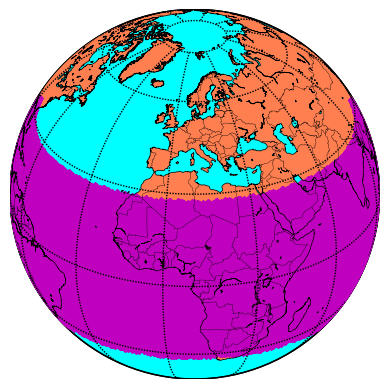

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

# set up orthographic map projection with
# perspective of satellite looking down at 45N, 100W.
# use low resolution coastlines.
map = Basemap(projection='ortho',lat_0=30,lon_0=10,resolution='l')

# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.5)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='coral',lake_color='aqua')

# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='aqua')

# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

# Plot lon and lat coordinates on the map
x, y = map(lon_coordinates, lat_coordinates)
map.scatter(x, y, marker='D', color='m')

p, q = map(12.916667, 50.833332)
map.scatter(p, q, marker="o", color="b")

# plot labels
plt.title("Epic Satellite Image Centroid Coordinates")

plt.show()



In [9]:
df_lat = pd.DataFrame(lat_coordinates)
df_lon = pd.DataFrame(lon_coordinates)
print("lat describe: ")
print(df_lat.describe())
print("---------------")
print("lon describe: ")
print(df_lon.describe())

lat describe: 
                  0
count  39359.000000
mean       4.399146
std       16.958279
min      -29.274902
25%       -9.228516
50%        8.811035
75%       19.519043
max       26.770020
---------------
lon describe: 
                  0
count  39359.000000
mean       3.941364
std      101.847247
min     -179.963379
25%      -83.803711
50%        5.866699
75%       91.567383
max      180.000000


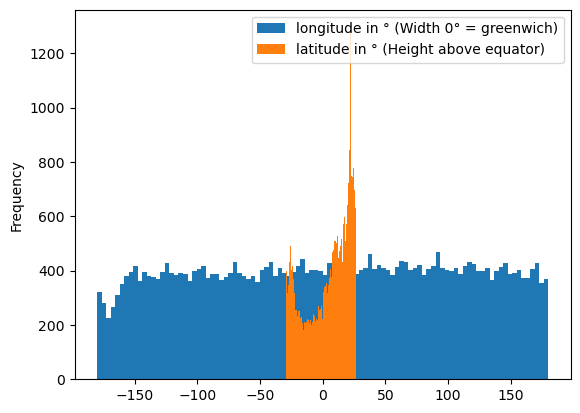

In [10]:
# make distribution of lat and lon
plt.hist(lon_coordinates, bins=100, label="longitude in ° (Width 0° = greenwich)")
plt.ylabel("Frequency")
plt.hist(lat_coordinates, bins=100, label="latitude in ° (Height above equator)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


![Explanation for you <3](https://s3.us-east-2.amazonaws.com/journeynorth.org/images/graphics/mclass/Lat_Long.gif)